<a href="https://colab.research.google.com/github/paruliansaragi/cnn-fastai/blob/master/fastai_dl3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install fastai

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00600.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_007680.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04050.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01440_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01620_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08069_P.png')]

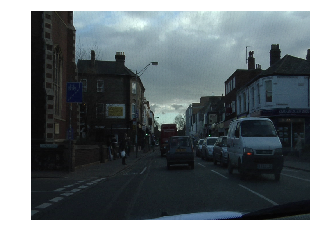

In [0]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

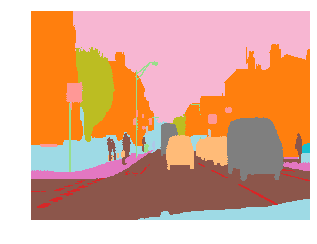

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
doc(open_mask)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
doc(SegmentationItemList)

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

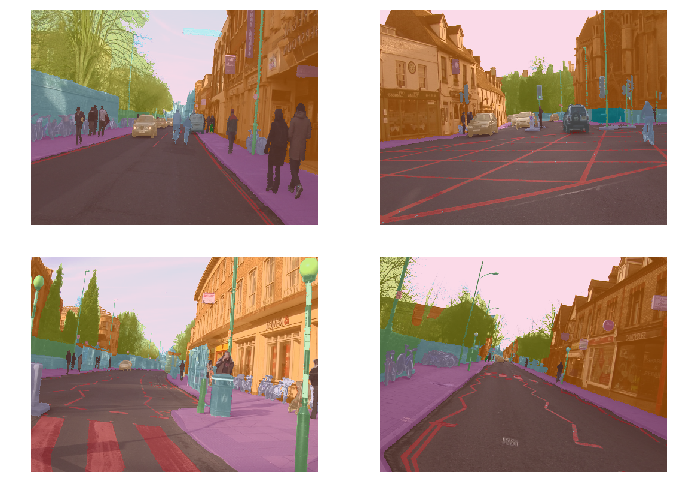

In [0]:
data.show_batch(2, figsize=(10,7))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


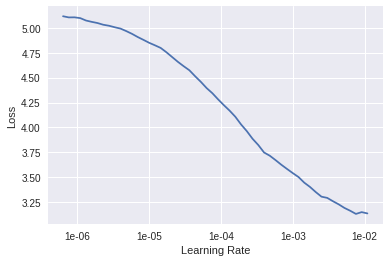

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
learn.save('stage-1')

epoch,train_loss,valid_loss,acc_camvid,time
0,1.162542,0.829376,0.799224,03:32
1,0.834617,0.584606,0.847368,03:22
2,0.713698,0.594637,0.842925,03:23
3,0.629408,0.617720,0.814951,03:22
4,0.621737,0.464863,0.877495,03:22
5,0.591493,0.461562,0.871416,03:21
6,0.617399,0.445988,0.868927,03:20
7,0.560307,0.546835,0.853189,03:20
8,0.661428,0.587871,0.847892,03:20
9,0.535052,0.368992,0.890163,03:18


In [0]:
learn.load('stage-1')
learn.show_results(rows=3, figsize=(8,9))

In [0]:
model = learn.load('stage-1')

In [0]:
!mv ./IMG1.jpg dataset

In [0]:
src = (SegmentationItemList.from_folder('./dataset'))

In [0]:
new_img = (src).databunch(bs=1).normalize(imagenet_stats)

In [0]:
pred = model.predict(img)

In [0]:
doc(learn.show_results)

In [0]:
doc(learn.export)

In [0]:
learn.export()

In [0]:
learn = load_learner('stage-1')

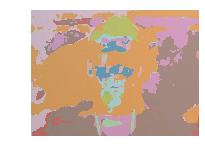

In [0]:
img2.show(y=model.predict(img2)[0])

In [0]:
img2_f = './IMG1.jpg'
img2 = open_image(img2_f)
img2.show(figsize=(5,5))

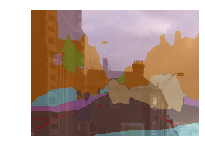

In [0]:
img.show(y=model.predict(img)[0])